### Co2 Migration Monitoring with ML

In [ ]:
import numpy as np
import pandas as pd
import pyvista as pv
import lasio
import sys
sys.path.append(r'.\co2_optimizer\src')
from sleipner_processor import SleipnerProcessor

import os 

In [ ]:
def run_sleipner_simulation():
    """
    Run the complete Sleipner CO2 storage simulation with Layer 9 analysis
    with improved error handling
    """
    # Set paths
    data_dir = r".\co2_optimizer\data\all_raw"
    grid_file = os.path.join(data_dir, "Sleipner_Reference_Model.grdecl")
    output_dir = os.path.join(data_dir, "sleipner_results")
    
    # Well data files
    well_log_file = os.path.join(data_dir, "159-A-16.las")
    well_pos_file = os.path.join(data_dir, "15_9_A16_wellposition")
    
    # Only the velocity maps we need for Layer 9 analysis
    pre_injection_file = os.path.join(data_dir, "1994_Top_Base_Utsira_Fm_Trend")
    pre_injection_name = "pre_TopUtsira_BaseUtsira"
    
    post_injection_file = os.path.join(data_dir, "Ext_TopUtsiraFm-Ref7")
    post_injection_name = "post_TopUtsira_Ref7"
    
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize processor
    processor = SleipnerProcessor(data_dir)
    
    # Load grid data
    try:
        processor.load_grid_data(grid_file)
    except Exception as e:
        print(f"Error loading grid data: {e}")
    
    # # Load plume boundary file
    processor.load_plume_boundary('L9')   
    
  
    # Load well data
    if os.path.exists(well_log_file):
        try:
            processor.load_well_data(well_log_file, data_type='log')
        except Exception as e:
            print(f"Error loading well log data: {e}")
    
    if os.path.exists(well_pos_file):
        try:
            processor.load_well_data(well_pos_file, data_type='position')
        except Exception as e:
            print(f"Error loading well position data: {e}")
    
    # Load only the two velocity maps we need
    pre_result = None
    post_result = None
    
    if os.path.exists(pre_injection_file):
        try:
            pre_result = processor.load_velocity_map(pre_injection_file, pre_injection_name, map_type='pre-injection')
            if pre_result is not None:
                print(f"Successfully loaded pre-injection map: {pre_injection_name}")
        except Exception as e:
            print(f"Error loading pre-injection velocity map: {e}")
    
    if os.path.exists(post_injection_file):
        try:
            post_result = processor.load_velocity_map(post_injection_file, post_injection_name, map_type='post-injection')
            if post_result is not None:
                print(f"Successfully loaded post-injection map: {post_injection_name}")
        except Exception as e:
            print(f"Error loading post-injection velocity map: {e}")
    
    # Create binary grid
    try:
        processor.create_binary_plume_grid()
    except Exception as e:
        print(f"Error creating binary plume grid: {e}")
        
    # Check if binary grid was created successfully
    if processor.binary_grid is None:
        print("Warning: Binary plume grid could not be created")
    
    # Run basic simulation
    results = {}
    try:
        # Set include_ml=False to skip machine learning predictions
        # since we're only focusing on Layer 9 analysis
        results = processor.run_simulation(output_dir, include_ml=True, clip_to_plume= True, time_factors=[1, 1.5, 2, 2.5, 3, 10])
        print("Basic simulation completed successfully")
    except Exception as e:
        print(f"Error running basic simulation: {e}")
    
    # Layer 9 specific analysis
    if pre_injection_name in processor.velocity_maps and post_injection_name in processor.velocity_maps:
        print("\nPerforming Layer 9 velocity analysis...")
        try:
            vel_diff, saturation = processor.analyze_layer_velocities(
                'L9', pre_injection_name, post_injection_name
            )
            
            if vel_diff is not None and saturation is not None:
                # Visualize Layer 9 results
                save_path = os.path.join(output_dir, 'L9_analysis.png')
                processor.visualize_layer_results('L9', save_path)
                print("Layer 9 analysis completed successfully")
        except Exception as e:
            print(f"Error in Layer 9 analysis: {e}")
    else:
        print("Could not perform Layer 9 analysis - velocity maps not available.")
    
    # Display summary
    print(f"\nSimulation complete! Results saved to {output_dir}")
    print("\nSummary:")
    
    if processor.binary_grid is not None:
        try:
            metrics = processor.calculate_plume_metrics()
            if metrics:
                print(f"  Current plume: {metrics['plume_cells']} cells, {metrics['co2_mass_tonnes'] / 1e6:.2f} million tonnes")
        except Exception as e:
            print(f"Error calculating summary metrics: {e}")
    
    # Display Layer 9 results if available
    if 'L9' in processor.results:
        try:
            stats = processor.results['L9'].get('statistics', {})
            if stats:
                mean_sat = stats.get('mean_sat')
                co2_cells = stats.get('co2_cells')
                total_cells = stats.get('total_cells')
                
                if mean_sat is not None and co2_cells is not None:
                    print(f"\nLayer 9 Analysis:")
                    print(f"  Mean saturation: {mean_sat:.3f}")
                    print(f"  CO2 presence: {co2_cells}/{total_cells} cells")
        except Exception as e:
            print(f"Error displaying Layer 9 results: {e}")
    
    return processor, results

      

Loading grid data from C:\Users\L1155225\OneDrive - TotalEnergies\co2_optimizer\data\all_raw\Sleipner_Reference_Model.grdecl
  Grid dimensions: (np.int64(64), np.int64(118), np.int64(263))
  Grid sections: ['MAPAXES', 'SPECGRID', 'COORD', 'ZCORN', 'ACTNUM', 'REGIONS', 'PORO', 'PERMX']
Loading plume boundary from L9 as L9
  Found 5 segments with 566 points
Loading well log data for Well_1 from C:\Users\L1155225\OneDrive - TotalEnergies\co2_optimizer\data\all_raw\159-A-16.las
  Loaded with lasio: 20766 rows, 6 columns
Loading well position data for Well_2 from C:\Users\L1155225\OneDrive - TotalEnergies\co2_optimizer\data\all_raw\15_9_A16_wellposition
  Loaded as CSV: 245 rows, 1 columns
Loading pre-injection map 'pre_TopUtsira_BaseUtsira' from C:\Users\L1155225\OneDrive - TotalEnergies\co2_optimizer\data\all_raw\1994_Top_Base_Utsira_Fm_Trend
  Note: Missing values detected in velocity map, filling with interpolation
  Loaded velocity map: (24417, 6)
Successfully loaded pre-injection map:

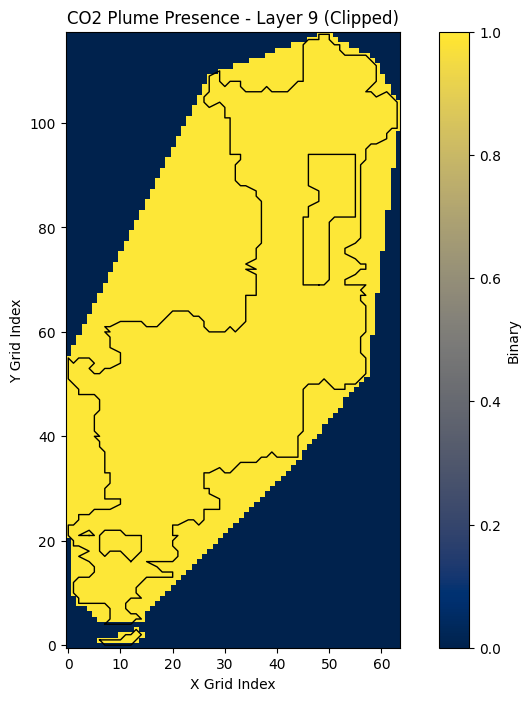

In [3]:
if __name__ == "__main__":
    try:
        processor, results = run_sleipner_simulation()
        print("Script completed successfully")
    except Exception as e:
        print(f"Unhandled error in main script: {e}")